<a href="https://colab.research.google.com/github/codiezodie/Image-Recognition/blob/main/cnngodcat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Download a ready-to-use Cats & Dogs dataset (already split into train/validation)
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip -d /content/

# 2) Paths
base_dir = "/content/cats_and_dogs_filtered"
train_dir = f"{base_dir}/train"
val_dir   = f"{base_dir}/validation"

# Quick check the folders exist
import os
print("Train exists:", os.path.isdir(train_dir))
print("Val exists  :", os.path.isdir(val_dir))


Train exists: True
Val exists  : True


In [ ]:
import tensorflow as tf
from tensorflow import keras

IMG_SIZE   = (256, 256)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

# Load images from directories (labels inferred from folder names)
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Optional: see the class names (['cats', 'dogs'])
print("Classes:", train_ds.class_names)

# Normalize pixels to [0,1]
def process(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(process, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(process, num_parallel_calls=AUTOTUNE)

# Performance: cache + prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(AUTOTUNE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [ ]:
from keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,396,641 (28.22 MB)

 Trainable params: 7,396,641 (28.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5396 - loss: 0.8221 - val_accuracy: 0.5560 - val_loss: 0.6883
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6248 - loss: 0.6562 - val_accuracy: 0.6670 - val_loss: 0.6219
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6926 - loss: 0.5866 - val_accuracy: 0.6390 - val_loss: 0.6379
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7484 - loss: 0.5040 - val_accuracy: 0.6730 - val_loss: 0.6876
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8438 - loss: 0.3351 - val_accuracy: 0.6860 - val_loss: 0.7240
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9216 - loss: 0.2002 - val_accuracy: 0.6680 - val_loss: 1.0321
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9345 - loss: 0.1652 - val_accuracy: 0.6840 - val_loss: 1.1038
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9756 - loss: 0.0723 - val_accuracy: 0.6800 - v

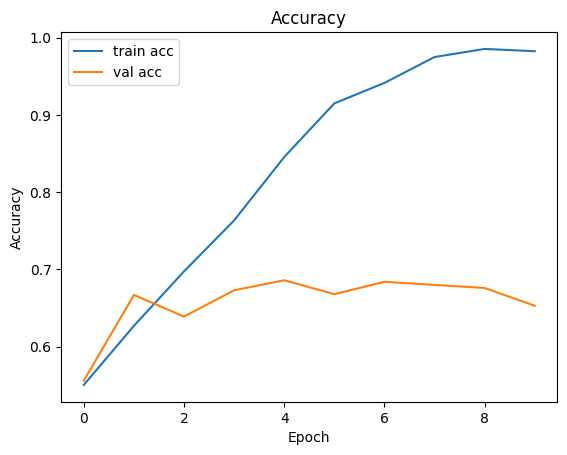

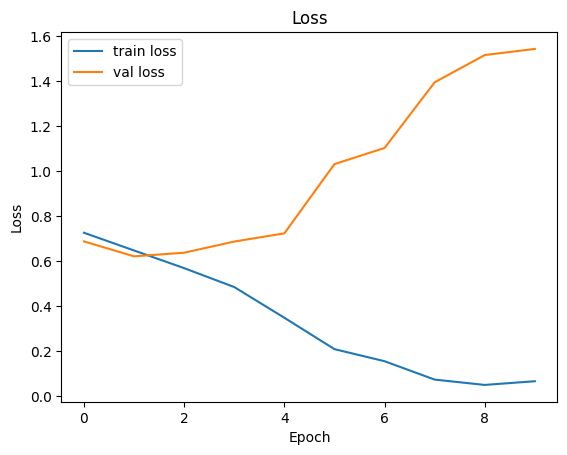

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
